# Using BERT to quantify the predictability of writing style

Transformer-based models of language such as BERT have been used create state-of-the-art models for a wide range of NLP tasks over the past few years. 
BERT's next-sentence prediction's capability have recently been used to <a href='https://tedunderwood.com/2020/07/05/how-predictable-is-fiction/'>assess the predictability of fiction.</a> 
This notebook attempts to use another task that BERT can be trained on, masked language modeling, to assess the predictability of style within a single sentence.

In lay language, masked language modeling can be described as a fill-in-the-blanks task. A model is given a sentence, each token in the sentence is hidden and the model made to predict it using the surrounding context words. The idea is that we can use the probabilities generated by such a model to assess how predictable the style of a sentence is. For instance, in the following English language sentence:

    His hair as gold as the sun , his eyes blue like the [MASK].

BERT (English) can predict `sky` with a 27.1% probability. But in the this sentence:

    `The [MASK] above the port was the color of television, tuned to a dead channel`

the probability of `sky` falls much lower, with BERT instead giving tokens such as `screen`, `window` or `panel` the highest probabilities - since the comparison to television makes the presence of the word less predictable. In short, BERT is better at predicting boilerplate than original writing. 

<br>
<br>

I would like to extend this beyond the scope of a single word and onto the scale of a complete sentence, i.e. evaluating a sentence's predictability. This approach makes sense because the way BERT computes probability would reflect a couple of things typically associated with literary originality: 
- the "preciosity" of a word (given two synonyms, the rarer one will receive a lower probability)
- the unexpectedness of comparison and literary or poetic language (we might say, in structuralist terms, that BERT's probabilities are computed following paradigmatic (predicting a word over others) and syntagmatic (based on its context) axes, whose order are subverted by the "poetic function" of language)

This predictability score could then be used as a metric for literary creativity. Being able to quantify such a value would be interesting for literary history and comparative literature, for instance if we were to compare it against signs of literary recognition (literary prizes, publication in prestigious or non-prestigious publishing houses...), enabling us to evaluate how much a certain literary culture values conformity over creativity (or vice-versa) at a certain point in time.

<br>
<br>

The insight that a language model can be used to assert how "common" the style of sentence is not entirely new. The scoring of sentences by language models, known as <a href='https://en.wikipedia.org/wiki/Perplexity#:~:text=of%20size%20N).-,Perplexity%20per%20word,over%20entire%20sentences%20or%20texts.'>perplexity</a> has been used in tasks such as automatic translation to rate which of the outputs of a model might be the most well-formed sentence in a particular target language. The main differences with our case are that:
1. Traditional language models are sequential, working from left to right, (they don't use the whole sentence as context to predict a single word).
2. Working with literary texts, we can assume that the sentences we will feed into the model will be generally gramatically correct (or intentionally incorrect). This allows us to be more selective in the categories of word we want to evaluate, skipping pronouns or particles (*still requires further investigation*).

Regarding point 1, BERT gives us an advantage over sequential language models. Because it is bi-directional, it allows us to consider the context on both sides of a word, which is closer to how a human reader would assert the unexpectedness of a single word within a sentence. One <a href=' https://arxiv.org/pdf/1906.00363.pdf'>paper</a> averaged the probabilities of the tokens in a sentence ($\prod_{i=1}^{n}p(w_{i}|w_{1},...,w_{i-1},w_{i+1},...,w_{n}))^{-1/n} $) to predict whether a sentence is non-sensical or not - similar to how the perplexity score is used by sequential language models.

Point 2 is tied to language specific issues, adressed below.

### Language specifics

Working with Korean and with literary texts, the above formula seems to present some limitations. For instance, Korean can mark the object of a verb with a specific particle (를/을). Predicting this particle being present between a noun and a verb is not hard (tokenizers such as BERT's separate it from the noun to which it would be attached). Therefore the token would be assigned a high probability. However, case particles can and are often omitted depending on context and individual preferences. Including it in the scoring of a sentence might therefore introduce bias, ranking writers who use it extensively as less creative than writers who use it more sparingly. On the other hand, as noted in Point 2 above, we are not interested in evaluating the grammatical correctness of a sentence, and therefore including case particles bring little additional information to our metric. The same is true of punctuation, pronouns, prepositions... We therefore opt to restrict the model to predicting masked nouns, adjectives and verbs (all tokens are still nonetheless used as context).

### Technical specifics

This approach requires us to be able to control the tokenization process because we want to be able to select the words which we will mask for prediction. Because most implementations of BERT uses a type of tokenizer that works splitting more complex words into smaller words to retain a small vocabulary size. This choice of tokenizing method is a powerful way to deal with out-of-vocabulary words (they will be split into smaller, in-vocabulary pieces). 

To address this issue, I've pre-tokenized the training data used during fine-tuning. I then train a new tokenizer with a large dictionary size and use its vocabulary to update the tokenizer's vocabulary of the base BERT model used for fine-tuning. (see <a href='https://github.com/digitalprk/sih_notebooks/blob/master/run_language_modeling.py'>here</a>). (Note that this extra step would not be needed if we did not want to exclude certain grammatical categories: we could simply use the mean of the probabilities of the differents parts of a word that was split as the probability of that word).

The base model used was <a href='https://github.com/SKTBrain/KoBERT'>KoBERT</a>, a BERT model trained by the SK Telecom team on South Korean language data. The model was fine-tuned on a small (1.6Gb) corpus of North Korean language data comprising novels, literary journals, newspapers, non-fiction books and the complete works of Kim Il-Sung and Kim Jong-Il.

### Data

10000 Sentences were extracted from four types of sources:
1. The Korean Central News Agency (the North Korean state's press agency)
2. Novels by prestigious writers (recognized for their literary excellence with a state sanctioned distinction)
3. Novels by "regular" writers
4. Canonical novels (fictional accounts of the lives of Kim Il-Sung and Kim Jong-Il held to be of the highest literary quality). 
5. Collections of poetry

None of the novels or press releases used were present in the corpus used to fine-tune the model. However, the corpus did contain similar content (literary sources and press releases for different years). All content used came from the years 1967 - 2018.

### Results

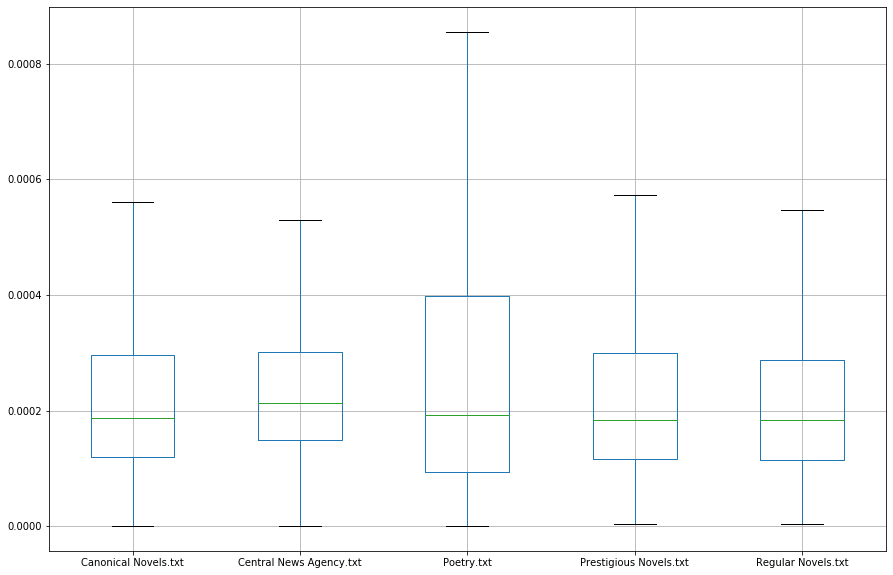

In [10]:
%matplotlib inline
df.boxplot(figsize = (15, 10), showfliers=False)

In [11]:
df.describe()

,Canonical Novels.txt,Central News Agency.txt,Poetry.txt,Prestigious Novels.txt,Regular Novels.txt
count,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000
mean,0.000251,0.000243,3.717125e-04,0.000257,0.000246
std,0.000270,0.000141,7.810524e-04,0.000307,0.000247
min,0.000000,0.000000,4.595703e-07,0.000004,0.000003
25%,0.000120,0.000149,9.288890e-05,0.000116,0.000115
50%,0.000187,0.000214,1.920330e-04,0.000184,0.000183
75%,0.000297,0.000301,3.979100e-04,0.000299,0.000288
max,0.008501,0.002298,3.953910e-02,0.007767,0.004886


In [12]:
from scipy import stats
from itertools import combinations
for a, b in list(combinations(df.columns, 2)):
    print(f'{a} : {b}')
    print(stats.ttest_ind(df[a],df[b]))

Canonical Novels.txt : Central News Agency.txt
Ttest_indResult(statistic=2.552955486164272, pvalue=0.010688673312532326)
Canonical Novels.txt : Poetry.txt
Ttest_indResult(statistic=-14.648423341306692, pvalue=2.4547739726797334e-48)
Canonical Novels.txt : Prestigious Novels.txt
Ttest_indResult(statistic=-1.4728912652748583, pvalue=0.14079609596087897)
Canonical Novels.txt : Regular Novels.txt
Ttest_indResult(statistic=1.3942278524406801, pvalue=0.16326429911179666)
Central News Agency.txt : Poetry.txt
Ttest_indResult(statistic=-16.231165951078893, pvalue=7.223306925742566e-59)
Central News Agency.txt : Prestigious Novels.txt
Ttest_indResult(statistic=-4.08177938362255, pvalue=4.486578683061665e-05)
Central News Agency.txt : Regular Novels.txt
Ttest_indResult(statistic=-0.9394757646506924, pvalue=0.34749787648814956)
Poetry.txt : Prestigious Novels.txt
Ttest_indResult(statistic=13.705254034128503, pvalue=1.4707000490328944e-42)
Poetry.txt : Regular Novels.txt
Ttest_indResult(statistic=1

### Comments

- The method seems to be at least working for discriminating between discursive genres
- Poetry might be expected to be the genre with the most creative writing, however the higher predictability of contemporary North Korean poetry is not really surprising for anyone unfortunate enough to be familiar with it.
- The method shows little significant difference between subgroups of fiction writing. This may be because there's none and all rely, on average, on the same amount of boilerplate. Comparisons between individual writers might be more meaningful. Other possibilities: issues with the fine-tuned model, wrong assumption that the method can be used indiscriminately on any sentence of a text (need to filter at least dialogue, or select for metaphoric sentences with metaphor detection, wrong assumption that the method actually works as intended...)

<hr>

## Code

In [1]:
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch
import logging
import numpy as np
import pickle

logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

tokenizer = AutoTokenizer.from_pretrained("./jobert")
model = AutoModelWithLMHead.from_pretrained("./jobert")

I0922 20:18:56.668476 39944 file_utils.py:39] PyTorch version 1.6.0 available.
I0922 20:18:58.622256 39944 file_utils.py:55] TensorFlow version 2.2.0 available.
I0922 20:18:59.258558 39944 configuration_utils.py:262] loading configuration file ./jobert\config.json
I0922 20:18:59.259525 39944 configuration_utils.py:300] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "type_vocab_size": 2,
  "vocab_size": 20839
}

I0922 20:18:59.260535 39944 tokenization_utils_base.py:1167] Model name './jobert' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-lar

In [2]:
from konlpy.tag import Komoran
komoran = Komoran()

In [3]:
def compute_word_proba(sequence, word):
    global model, tokenizer
    input_ids = tokenizer.encode(sequence, return_tensors="pt")
    mask_token_index = torch.where(input_ids == tokenizer.mask_token_id)[1]
    token_logits = model(input_ids)[0]
    mask_token_logits = token_logits[0, mask_token_index, :]
    mask_token_logits = torch.softmax(mask_token_logits, dim=1)
    sought_after_token = word
    sought_after_token_id = tokenizer.encode(sought_after_token, add_special_tokens=False, add_prefix_space=True)[0]
    token_score = mask_token_logits[:, sought_after_token_id]
    return token_score.detach().numpy()[0]

def compute_word_by_word_proba(sequence):
    global tokenizer
    global komoran
    pos_filter = ['VV', 'VA', 'NNG', 'NNP', 'MAG', 'NA', 'SN', 'NR', 'XR'] # we only want to predict verbs, nouns and adjectives
    word_dict = {}
    tokenized_sequence = komoran.pos(sequence)
    sequence = ' '.join([token for token, pos in tokenized_sequence])
    for token, pos in tokenized_sequence:
        #print(token, pos)
        if pos in pos_filter:
            masked_sequence = sequence.replace(token, tokenizer.mask_token)
            word_dict[token] = compute_word_proba(masked_sequence, token)
    return word_dict

def geometric_mean(series):
    return np.array(series, dtype=np.float64).prod()**(1.0/len(series))

def compute_sentence_score(sentence):
    return geometric_mean(list(compute_word_by_word_proba(sentence).values()))

In [5]:
import os
from tqdm import tqdm


sample_data_path = './samples'
sample_files = [file for file in os.listdir(sample_data_path) if not file.endswith('-tokenized.txt')]
final_results = {}
for file in sample_files:
    with open(os.path.join(sample_data_path, file), 'r', encoding='utf8') as fp:
        sentences = fp.read().splitlines()
    scores = []
    print(file)
    for i, sentence in enumerate(tqdm(sentences)):
        try:
            score = compute_sentence_score(sentence.replace('\xa0 ', ''))
            scores.append(score)
        except Exception as e:
            scores.append(np.mean(scores))
            print("Error:", sentence)
            print(e)
            pass
    
    final_results[file] = scores
    
#with open('/project/RDS-FASS-NKBert-RW/samples/final_scores.pkl', 'wb') as fp:
#    pickle.dump(final_results, fp)


Canonical Novels.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:34:02<00:00,  1.30it/s]


Central News Agency.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [3:43:23<00:00,  2.03s/it]


Poetry.txt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [19:56<00:00,  8.62it/s]


Prestigious Novels.txt


  5%|████████▍                                                                                                                                                          | 516/10000 [04:06<1:54:47,  1.38it/s]

Error: ≪그가 무엇 때문에 여기에 왔지?
float division by zero


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:23:32<00:00,  1.82it/s]


Regular Novels.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:18:22<00:00,  2.80it/s]


In [6]:
import pandas as pd
df = pd.DataFrame(final_results)
df

,Canonical Novels.txt,Central News Agency.txt,Poetry.txt,Prestigious Novels.txt,Regular Novels.txt
0,0.000140,0.000181,0.000047,0.000030,0.000079
1,0.000369,0.000135,0.000053,0.000111,0.000200
2,0.000126,0.000354,0.001218,0.000450,0.000109
3,0.000076,0.000345,0.000088,0.000226,0.000079
4,0.000206,0.000132,0.000467,0.000308,0.000136
...,...,...,...,...,...
9995,0.000259,0.000228,0.000096,0.000259,0.000151
9996,0.000187,0.000189,0.000297,0.000161,0.000127
9997,0.000136,0.000141,0.000169,0.000115,0.000887
9998,0.000147,0.000330,0.000036,0.000213,0.000354


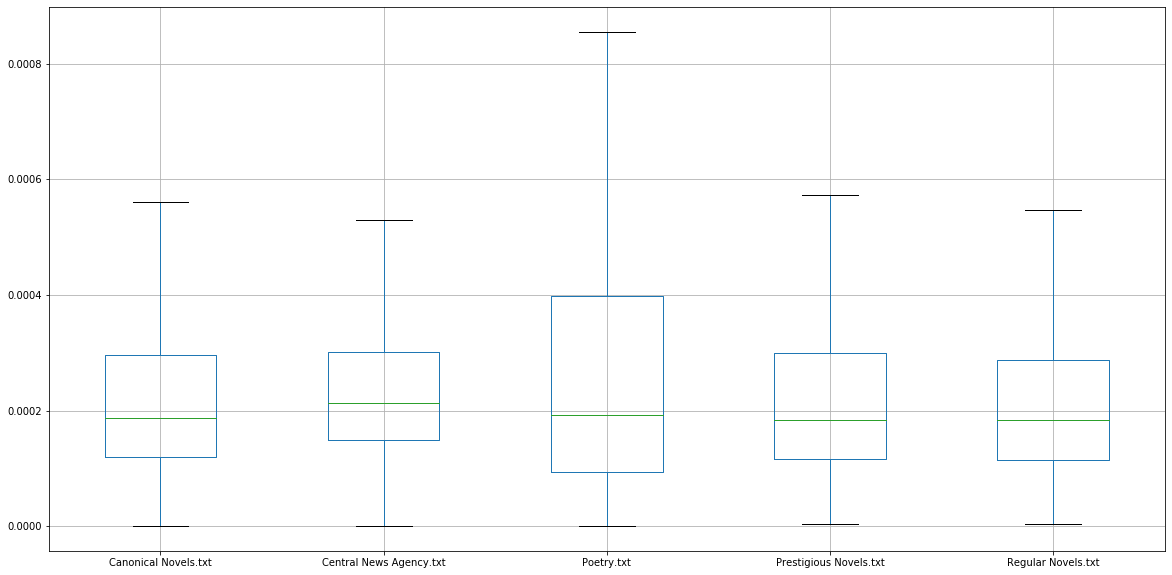

In [7]:
%matplotlib inline
df.boxplot(figsize = (20, 10), showfliers=False)

In [8]:
df.describe()

,Canonical Novels.txt,Central News Agency.txt,Poetry.txt,Prestigious Novels.txt,Regular Novels.txt
count,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000
mean,0.000251,0.000243,3.717125e-04,0.000257,0.000246
std,0.000270,0.000141,7.810524e-04,0.000307,0.000247
min,0.000000,0.000000,4.595703e-07,0.000004,0.000003
25%,0.000120,0.000149,9.288890e-05,0.000116,0.000115
50%,0.000187,0.000214,1.920330e-04,0.000184,0.000183
75%,0.000297,0.000301,3.979100e-04,0.000299,0.000288
max,0.008501,0.002298,3.953910e-02,0.007767,0.004886


In [9]:
from scipy import stats
from itertools import combinations
for a, b in list(combinations(df.columns, 2)):
    print(f'{a} : {b}')
    print(stats.ttest_ind(df[a],df[b]))

Canonical Novels.txt : Central News Agency.txt
Ttest_indResult(statistic=2.552955486164272, pvalue=0.010688673312532326)
Canonical Novels.txt : Poetry.txt
Ttest_indResult(statistic=-14.648423341306692, pvalue=2.4547739726797334e-48)
Canonical Novels.txt : Prestigious Novels.txt
Ttest_indResult(statistic=-1.4728912652748583, pvalue=0.14079609596087897)
Canonical Novels.txt : Regular Novels.txt
Ttest_indResult(statistic=1.3942278524406801, pvalue=0.16326429911179666)
Central News Agency.txt : Poetry.txt
Ttest_indResult(statistic=-16.231165951078893, pvalue=7.223306925742566e-59)
Central News Agency.txt : Prestigious Novels.txt
Ttest_indResult(statistic=-4.08177938362255, pvalue=4.486578683061665e-05)
Central News Agency.txt : Regular Novels.txt
Ttest_indResult(statistic=-0.9394757646506924, pvalue=0.34749787648814956)
Poetry.txt : Prestigious Novels.txt
Ttest_indResult(statistic=13.705254034128503, pvalue=1.4707000490328944e-42)
Poetry.txt : Regular Novels.txt
Ttest_indResult(statistic=1

In [32]:
from scipy import stats
stats.ttest_ind(df['novels.txt'], df['novels-415.txt'])

Ttest_indResult(statistic=-1.6062157018139056, pvalue=0.10825810476960021)

In [7]:
poem = ['예순여해!', 
'세월은 많이 흘렀어도', 
'지나간 추억의 이야기 아니여라', 
'오늘도 우리앞에', 
'통일로 펼쳐지는 이야기', 
'해방후', 
'38°선이 처음 그어질 땐 북녘땅', 
'전쟁이 끝난 다음엔 남녘땅', 
'강원도 고성군 화진포에 깃든', 
'못 잊을 8월이야기', 
'절세의 위인들 사랑 뜨거운', 
'여름이야기여', 
'해방!', 
'해방은 되였어도', 
'그 기쁨 다 모르고 사는 고장', 
'산넘어 38°선이 보이는', 
'초도리 화진포', 
'해종일 물밑을 뒤져도', 
'모래밭에 널린 조가비처럼', 
'아직도 가난이 널린 마을', 
'이따금 쿵쿵 포소리 울려와', 
'사람들 불안을 안고사는 화진포', 
'그래도 경치는 수려했다', 
'은빛모래밭에 진분홍색 해당화', 
'남색의 파도우에 거부기모양의 섬', 
'섬우엔 병풍처럼 펼쳐진 푸른 솔숲', 
'그 솔숲에서 봄이면 날려오는', 
'노란 솔꽃가루 물결에 실리고', 
'여름내내 해당화 진한 향기', 
'바람타고 감도는 포구여서', 
'그 이름도 화진포', 
'그날이였다', 
'해방전 가진자들의 흥타령 울리던', 
'해변가 신작로따라', 
'차창에 석양빛 싣고', 
'달려오는 승용차 한대', 
'해넘이경치 보러오는걸가', 
'해당화 꽃구경 오는걸가', 
'하늘가엔 노을도 곱게 피는데', 
'어인 일인가', 
'기울어진 울바자 힘겹게 서있는', 
'마을어구에서 문득 멈춰서는 승용차', 
'슬픔을 먹고자란 생명인가', 
'시들은 유채꽃처럼', 
'얼굴이 노랗게 뜬 어린 소녀', 
'바다쪽에 눈길을 얹고', 
'마을길에 서있었다', 
'가난이 숨길수 없이 내비친듯', 
'다섯발가락이 다 나온', 
'터진 고무신을 신고 서있는 소녀', 
'그 모습에 눈길을 떼지 못하시며', 
'차에서 내리신 현숙한 녀사분과 자제분', 
'불쌍한 아이들을 두고서는', 
'눈물도 많으신분', 
'38°선 가까이서 그 모습을 보니', 
'가슴에 소금이 뿌려진듯', 
'더 아파 못 견디시는', 
'아, 그분은', 
'항일의 녀장군 김정숙어머님', 
'－몇살이예요?', 
'－여섯살!', 
'－왜 여기 서있나요?', 
'－아빠가 보고싶어서…', 
'－아빠는 어디 가셨게?', 
'－고기잡이 나갔다가', 
'  38°선이 막혀 못 온대요', 
'  돌아오면 꽃신을 꼭 사주겠다고 했는데…', 
'꿰진 신발과 해진 옷을 걸치고', 
'분렬조국의 기슭에 나와선', 
'어린 소녀', 
'품에 꼭 껴안으신 어머님', 
'어머님 눈빛은', 
'저도몰래 젖어드셨다', 
'어릴적 부암동 하촌마을에서', 
'피덩이 어린 조카를 안고', 
'오빠를 기다리던 그날이 생각나', 
'그날의 자신의 모습', 
'여기서 다시 보는것만 같아', 
'진정 그랬다', 
'일제놈들때문에 당한', 
'그 생리별의 아픔', 
'해가고 달가도 가실길 없는데', 
'미국놈들때문에 또다시', 
'이런 비극 당해야 한단 말인가', 
'어머님은 비분을 누르시며', 
'조용히 말씀하신다', 
'－얘야 우리 경치좋은 이곳에', 
'  이제 학교랑 유희장이랑 짓자꾸나', 
'  그때면', 
'  새 옷도 새 신발도 다 거저주려 한다', 
'  헤여진 아버지도 만나구 … 좋지?', 
'순간,', 
'머리를 번쩍 든 소녀', 
'나서 처음 해빛을 마주한듯', 
'눈빛을 반짝이며 우러렀다', 
'다정하신 그분을', 
'가슴속에 무지개가 떴다', 
'그 고운 칠색에 고운 꿈을 실을제', 
'새 신을 안고 달려오신 자제분', 
'그분은 빨찌산의 아들 김정일장군님', 
'처녀애의 터진 고무신을 벗기고', 
'새 신발을 신겨주시였다', 
'－어서 신어라 이건 내 신발인데', 
'  네 발에 꼭 맞을거야', 
'  그리고 아빠때문에', 
'  너무 마음쓰지 말어', 
'  38°선 철조망을 걷어주시려', 
'  아버지 김일성장군님께서', 
'  우리 어머님과 함께 화진포에 오셨어', 
'화진포에 가면 신으라고', 
'수령님 사주신 신발', 
'어머님께서 신끈도 곱게 매여주시여', 
'아직 한번도 신지 않고', 
'아끼고아끼시던 새 구두', 
'아끼지 않고 주시였다', 
'겨레를 위해 늘 마음쓰시는', 
'수령님과 어머님사랑', 
'자신의 마음에 가득 담으시여', 
'아빠찾는 소녀의 가슴에', 
'기쁨으로 가득 안겨주시였다', 
'순간 솟구치는', 
'감사의 인사말 올리는것인가', 
'가랑가랑 눈굽에 구슬을 달고', 
'여섯살 어린 소녀', 
'아뢰인 다만 한마디', 
'오빠!－', 
'그렇다 그분이 누구신지', 
'소녀는 아직 알수 없었어도', 
'어린 가슴속에', 
'그분은 벌써 친오빠', 
'기쁨으로 우러른', 
'행복의 세상이시였다', 
'소녀는 달려간다', 
'새 신을 안고', 
'춤을 추듯 백사장으로', 
'아빠!－ 소리쳐 부르며', 
'그 소리', 
'바다가 멀리멀리 메아리치는데', 
'소녀가 찾는 아빠', 
'어디에 있는가', 
'어머님은 오래도록', 
'자리를 뜨지 못하신다', 
'산에서 얼고 굶으며', 
'피흘려 찾은 조국이건만', 
'마주하신것은', 
'갈라진 민족의 비극', 
'분렬의 아픈 상처', 
'산에서 10여성상 쌓이신 피로', 
'예와서 푸시면 얼마나 좋으랴', 
'해방된 조국의 명소에 오셨어도', 
'아름다운 경치 비켜서시여', 
'갈라진 겨레의 불행 안으시고', 
'자리를 뜨지 못하시나니', 
'오, 물어보자', 
'삼천리조국이여 화진포여', 
'너는 어머님께 아픔만 드리자고', 
'어제는 일제의 칼에 맞아 피흘리고', 
'오늘은 허리잘려 신음하느냐', 
'이렇게 오시였다 어머님은', 
'38°선이 보이는 분렬의 현장으로', 
'이 땅의 울분을 안으시고', 
'민족의 통한을 안으시고', 
'해방소원 안으셨던 가슴에', 
'통일소원 또다시 무겁게 안으시고', 
'차는 달린다 어둠을 뚫고', 
'아빠찾는 소녀의 모습', 
'갈라진 겨레의 아픔', 
'크나큰 위업속에 싣고', 
'오, 그날부터 화진포에', 
'어머님 휴식의 밤은 없었다', 
'2', 
'날이 밝았다', 
'아빠가 돌아오면 보여주리', 
'새 신발 가슴에 안고', 
'이른 새벽부터', 
'바다가 모래불에 나와 선', 
'어린 소녀', 
'철썩 처절썩－', 
'몇백 몇천번이나 파도는', 
'기슭에 달려와 안겨도', 
'오늘도 안 오시는 아빠', 
'언제면 오실가', 
'저녁노을 등에 지고', 
'맥없이 집에 들어서는데', 
'그만 눈이 휘둥그래졌다', 
'엄마와 함께 부엌에서', 
'터진 부뚜막 손질하시는분', 
'그분이 어제저녁 마을길에서 만난', 
'그 고마우신 어머님이시였으니', 
'소녀의 얼굴엔 웃음꽃이 활짝 폈다', 
'세상에서 제일 좋은 큰어머님', 
'엄마와 함께 계시기에', 
'기쁨속에 새겨들었다', 
'큰어머님 엄마와 나누시는 말씀', 
'－세대주가 돌아와서', 
'  부뚜막수리를 하겠다고 했는데…', 
'  녀사님께 페를 끼쳐 정말 미안해요', 
'－괜찮아요 이제 세대주가 돌아오면', 
'  기다린 정 만난정 다 합쳐', 
'  밥을 맛있게 지어 대접하자요!', 
'친혈육인듯', 
'다정한 언니 동생인듯', 
'웃으며 허물없이 이야기를 나눌 때', 
'어린 소녀 어느새 달려와 안겼다', 
'－엄마 내가 어제 말하던', 
'  그 큰어머님이야', 
'－해선아! 나도 그렇게 생각했다', 
'모를수 없었다', 
'그분이 아니시면', 
'누가 화진포에', 
'이렇듯 큰 사랑 안고오시랴', 
'김정숙어머님! 그 이름은', 
'나라를 찾아주신', 
'김일성장군님 태양존함과 더불어', 
'삼천리에 빛나는 해발!', 
'아이들 손잡고 로인들 앞세우고', 
'동리사람들이 모여왔다', 
'친정집어머님을 모신듯', 
'사람들 빙－ 둘러앉은 해선이네 집', 
'새 삶의 기쁨을 터치는', 
'글방인가 노래방인가 웃음방인가', 
'함께 오신 자제분 또박또박 써주신', 
'《삼천리 우리 나라》 글읽는 소리', 
'어머님 배워주신', 
'《김일성장군의 노래》 부르는 소리', 
'수령님 모신 통일조국에서 행복하게 살', 
'그날을 그려보는 웃음소리', 
'아, 분렬의 종처인양 옹기종기', 
'설음이 돋아있는 동네', 
'집집마다 가슴마다 기쁨을 채워주는', 
'백두에서 떠나온 사랑의 큰 세계여', 
'그 품에 안겨', 
'사랑이 무엇인지 하나씩 깨달아가는', 
'화진포사람들의', 
'글소리 노래소리 웃음소리여', 
'밤이 깊었다', 
'따로 마련한 숙소', 
'마다하시는 어머님께', 
'한 녀인이 말씀올린다', 
'－녀사님, 그럼 이 모기장만이라도…', 
'풀엉킨 산기슭의 작은 집', 
'여름밤 모기장이야 어이 마다하시랴', 
'하지만 어머님', 
'누에실로 엮은 수수한 모기장앞에', 
'생각깊이 이으시는 말씀', 
'－해선이 아버지랑 함께 간 사람들이', 
'  지금 혈육들 생각하며', 
'  밤거리를 헤매는지 어떻게 알겠어요', 
'  그런데 제가 어떻게 호강스럽게', 
'  비단모기장을 치고 눕겠어요?!', 
'이 무슨 말씀이신가', 
'산에서 눈깔고 가랑잎덮고 쉬시며', 
'겪으신 고생 얼마이신데', 
'그러면 우린 어떻게 하느냐며', 
'해선이 어머닌 울어버린다', 
'－해선이 어머니, 이러지 마세요', 
'  나에겐 모포 한장이면 돼요', 
'  지금 수령님께서는 조국의 통일을 위해', 
'  화진포사람들의 생활을 위해', 
'  이 밤도 지새고계셔요', 
'  조국이 통일되는 그날까지', 
'  나는 백두산에서 몸에 밴', 
'  유격대생활습성을 바꿀것 같지 못해요', 
'－녀사님!', 
'－김정숙어머님!', 
'아, 이 밤을 울었다', 
'숲속의 이름 모를 풀잎마저', 
'맑은 이슬 소리내여 떨구며', 
'못 이룬 통일앞에 서신 어머님껜', 
'수수한 견사모기장마저', 
'그리도 사치한것이란 말인가', 
'정녕', 
'이밤엔 어유등도', 
'안타까움에 타고탔다', 
'누구나 누리는 그 작은 권리', 
'어머님은 향유하시면 안되신단 말인가', 
'어느덧 밤은 깊어', 
'외로운 포구에 정적도 깊어', 
'화진포사람들 깊은 잠 들었건만', 
'마당가에 나오신', 
'김정숙어머님', 
'마음을 진정하지 못하신다', 
'만주벌 눈바람속에서', 
'풍찬로숙하며', 
'탄알이 비발치는 전장을', 
'총들고 달리시며', 
'시련을 넘어 죽음을 넘어', 
'기어이 찾은 조국이건만', 
'그 조국의 허리에', 
'가시철조망이 칭칭 감기고', 
'해방만세의 감격 터져올랐던', 
'이 8월의 여름하늘아래서', 
'얼어드는 가슴안고 사람들 살고있으니', 
'견딜수 없으시였다', 
'용납할수 없으시였다', 
'한몸을 깡그리 불태워서라도', 
'원한의 그 찬덩어리 모두 녹이리라', 
'어머님 가슴속에선 선언이 울리셨다', 
'오, 진정', 
'이 땅의 한사람한사람이', 
'자신의 체온다해 품어주시는', 
'친혈육 친자식이여서', 
'이 땅의 한치한치가', 
'자신의 몸 한부분 같으시여', 
'조국앞에 서신 어머님은 그대로', 
'금강석도 녹여버릴', 
'불덩이 지니신 사랑의 화신이시였다', 
'삼천리를 품으신 하늘이시였다', 
'진정 억만금이 있다 해도', 
'그를 위해 모두 바치셨을', 
'통일, 통일은 어머님의', 
'최고의 기쁨', 
'최상의 재부', 
'최대의 소원', 
'사모님이라 부르는것조차', 
'한번 허락지 않으시고', 
'김일성장군님 통일전사로', 
'낮과 밤을 이으시는 어머님이시여', 
'한몸을 깡그리 불태우시는 녀장군이시여']

In [14]:
scores_poem = []
for line in poem:
    if len(line) > 3:
        print(line)
        #print(komoran.pos(line))
        try:
            score = compute_sentence_score(line.strip())
        except:
            pass
        scores_poem.append(score)

예순여해!
세월은 많이 흘렀어도
지나간 추억의 이야기 아니여라
오늘도 우리앞에
통일로 펼쳐지는 이야기
38°선이 처음 그어질 땐 북녘땅
전쟁이 끝난 다음엔 남녘땅
강원도 고성군 화진포에 깃든
못 잊을 8월이야기
절세의 위인들 사랑 뜨거운
여름이야기여
해방은 되였어도
그 기쁨 다 모르고 사는 고장
산넘어 38°선이 보이는
초도리 화진포
해종일 물밑을 뒤져도
모래밭에 널린 조가비처럼
아직도 가난이 널린 마을
이따금 쿵쿵 포소리 울려와
사람들 불안을 안고사는 화진포
그래도 경치는 수려했다
은빛모래밭에 진분홍색 해당화
남색의 파도우에 거부기모양의 섬
섬우엔 병풍처럼 펼쳐진 푸른 솔숲
그 솔숲에서 봄이면 날려오는
노란 솔꽃가루 물결에 실리고
여름내내 해당화 진한 향기
바람타고 감도는 포구여서
그 이름도 화진포
그날이였다
해방전 가진자들의 흥타령 울리던
해변가 신작로따라
차창에 석양빛 싣고
달려오는 승용차 한대
해넘이경치 보러오는걸가
해당화 꽃구경 오는걸가
하늘가엔 노을도 곱게 피는데
어인 일인가
기울어진 울바자 힘겹게 서있는
마을어구에서 문득 멈춰서는 승용차
슬픔을 먹고자란 생명인가
시들은 유채꽃처럼
얼굴이 노랗게 뜬 어린 소녀
바다쪽에 눈길을 얹고
마을길에 서있었다
가난이 숨길수 없이 내비친듯
다섯발가락이 다 나온
터진 고무신을 신고 서있는 소녀
그 모습에 눈길을 떼지 못하시며
차에서 내리신 현숙한 녀사분과 자제분
불쌍한 아이들을 두고서는
눈물도 많으신분
38°선 가까이서 그 모습을 보니
가슴에 소금이 뿌려진듯
더 아파 못 견디시는
아, 그분은
항일의 녀장군 김정숙어머님
－몇살이예요?
－여섯살!
－왜 여기 서있나요?
－아빠가 보고싶어서…
－아빠는 어디 가셨게?
－고기잡이 나갔다가
  38°선이 막혀 못 온대요
  돌아오면 꽃신을 꼭 사주겠다고 했는데…
꿰진 신발과 해진 옷을 걸치고
분렬조국의 기슭에 나와선
어린 소녀
품에 꼭 껴안으신 어머님
어머님 눈빛은
저도몰래 젖어드셨다
어릴적 부암동 하촌마을에서
피덩이 어린 조카를 안고
오빠를 기다리던 그날이 생각나
그날의 자신

In [15]:
np.median(scores_poem)

0.00016278879475836874